# Add carbon prices

- Assume realistic cost parameters and lifetimes for this power plant type (include references your sources in the notebook)
- Is there a “sweet spot” of prices on carbon such that coal, wind & gas are used at the same time?

In [124]:
import pandas as pd
import ixmp
import message_ix

from message_ix.util import make_df

%matplotlib inline

In [125]:
mp = ixmp.Platform()

### Making a clone of the existing scenario 'gas_ppl'

Loading the existing scenario 'gas_ppl' and cloning to a new scenario 'emission' to add carbon prices

In [126]:
model = 'Westeros Electrified'
base = message_ix.Scenario(mp, model=model, scenario='gas_ppl')
scen = base.clone(model, 'emission', 'introduce emission taxes', keep_solution=False)
scen.check_out()

In [127]:
country = 'Westeros'
model_horizon = scen.set('year')
year_df = scen.vintage_and_active_years()
vintage_years, act_years = year_df['year_vtg'], year_df['year_act']

### Create carbon prices

In [130]:
# first we introduce the emission of CO2 and the emission category GHG
scen.add_set('emission', 'CO2')
scen.add_cat('emission', 'GHG', 'CO2')

# we now add CO2 emissions to the powerplants
base_emission_factor = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'standard',
    'unit': 'tCO2/kWa',
}


emission_factor = {
    'coal_ppl': 7.4,
    'gas_ppl': 6.6,
    'wind_ppl': 0,
}

for tec, val in emission_factor.items():
    df = make_df(base_emission_factor, technology=tec, emission= 'CO2', value=val)
    scen.add_par('emission_factor', df)

# adding new units to the model library (needed only once)
mp.add_unit('tCO2/kWa')
mp.add_unit('MtCO2')

INFO:root:unit `tCO2/kWa` is already defined in the platform instance
INFO:root:unit `MtCO2` is already defined in the platform instance


### Carbon prices

| technology | USD/kw |
|---------------|--------------|
| Coal     | 5    |
| Gas     | 4         |
| Wind     | 0         |

In [85]:
scen.par_list()

['commodity_stock',
 'demand',
 'resource_cost',
 'resource_remaining',
 'bound_extraction_up',
 'resource_volume',
 'technical_lifetime',
 'capacity_factor',
 'operation_factor',
 'min_utilization_factor',
 'inv_cost',
 'fix_cost',
 'var_cost',
 'output',
 'input',
 'abs_cost_new_capacity_soft_up',
 'abs_cost_new_capacity_soft_lo',
 'level_cost_new_capacity_soft_up',
 'level_cost_new_capacity_soft_lo',
 'abs_cost_activity_soft_up',
 'abs_cost_activity_soft_lo',
 'level_cost_activity_soft_up',
 'level_cost_activity_soft_lo',
 'bound_new_capacity_up',
 'bound_new_capacity_lo',
 'bound_total_capacity_up',
 'bound_total_capacity_lo',
 'bound_activity_up',
 'bound_activity_lo',
 'initial_new_capacity_up',
 'growth_new_capacity_up',
 'soft_new_capacity_up',
 'initial_new_capacity_lo',
 'growth_new_capacity_lo',
 'soft_new_capacity_lo',
 'initial_activity_up',
 'growth_activity_up',
 'soft_activity_up',
 'initial_activity_lo',
 'growth_activity_lo',
 'soft_activity_lo',
 'emission_factor',
 

In [131]:
base_tax_emission = {
    'node': 'Westeros',
    'type_year': [700, 710, 720],
    'type_tec': 'all',
    'unit': 'USD/tCO2',
    'type_emission': 'GHG',
    'value': 40
}

# in case you need to add the new unit to the platform
mp.add_unit('USD/tCO2')

tax_emission = make_df(base_tax_emission)
scen.add_par('tax_emission', tax_emission)
scen.par('tax_emission')

INFO:root:unit `USD/tCO2` is already defined in the platform instance


,node,type_emission,type_tec,type_year,value,unit
0,Westeros,GHG,all,700,40.0,USD/tCO2
1,Westeros,GHG,all,710,40.0,USD/tCO2
2,Westeros,GHG,all,720,40.0,USD/tCO2


## Run model

In [132]:
scen.commit(comment='introducing carbon pricing')

In [133]:
scen.solve()

In [134]:
scen.var('OBJ')['lvl']

716210.9375

In [135]:
scen.var_list()

['OBJ',
 'EXT',
 'STOCK',
 'CAP_NEW',
 'CAP',
 'ACT',
 'EMISS',
 'LAND',
 'REL',
 'DEMAND',
 'PRICE_COMMODITY',
 'PRICE_EMISSION',
 'COST_NODAL',
 'COST_NODAL_NET',
 'GDP',
 'I',
 'C']

## Results

In [136]:
# Create a Reporter object to describe and carry out reporting
# calculations and operations (like plotting) based on `scenario`
from message_ix.reporting import Reporter

rep = Reporter.from_scenario(scen)

# Add keys like "plot activity" to describe reporting operations.
# See tutorial/utils/plotting.py
from message_ix.util.tutorial import prepare_plots

prepare_plots(rep)

### Activity
How much energy is generated in each time period from the different potential sources?

<AxesSubplot:title={'center':'Westeros Energy System Activity'}, xlabel='Year', ylabel='GWa'>

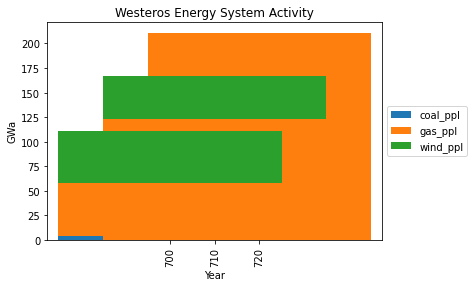

In [137]:
# Only show a subset of technologies in the follow plots;
# e.g. exclude "bulb" and "grid"
rep.set_filters(t=["coal_ppl", "wind_ppl", "gas_ppl"])

# Trigger the calculation and plotting
rep.get("plot activity")

In [138]:
activity = scen.var('ACT')
activity

,node_loc,technology,year_vtg,year_act,mode,time,lvl,mrg
0,Westeros,coal_ppl,690,700,standard,year,3.729384,0.000000e+00
1,Westeros,coal_ppl,700,700,standard,year,0.000000,0.000000e+00
2,Westeros,coal_ppl,700,710,standard,year,0.000000,4.361237e+02
3,Westeros,coal_ppl,710,710,standard,year,0.000000,2.939095e+02
4,Westeros,coal_ppl,710,720,standard,year,0.000000,2.677421e+02
5,Westeros,coal_ppl,720,720,standard,year,0.000000,3.562203e+02
6,Westeros,wind_ppl,690,700,standard,year,10.350076,0.000000e+00
7,Westeros,wind_ppl,700,700,standard,year,43.340788,0.000000e+00
8,Westeros,wind_ppl,700,710,standard,year,43.340788,0.000000e+00
9,Westeros,wind_ppl,710,710,standard,year,0.000000,1.679289e+02


In [139]:
print('Coal:', activity.loc[activity['technology'] == 'coal_ppl']['lvl'].sum())
print('Wind:', activity.loc[activity['technology'] == 'wind_ppl']['lvl'].sum())
print('Gas:', activity.loc[activity['technology'] == 'gas_ppl']['lvl'].sum())

Coal: 3.7293836914458893
Wind: 97.03165131616447
Gas: 388.1278538812786


### Capacity
How much capacity of each plant is installed in each period?

<AxesSubplot:title={'center':'Westeros Energy System Capacity'}, xlabel='Year', ylabel='GW'>

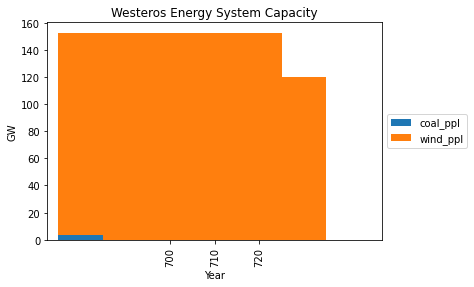

In [140]:
# Create a different plot. The same filters are still active.
rep.get("plot capacity")

In [141]:
capacity = scen.var('CAP')
capacity

,node_loc,technology,year_vtg,year_act,lvl,mrg
0,Westeros,coal_ppl,690,700,3.729384,0.000000
1,Westeros,coal_ppl,700,700,0.000000,386.086746
2,Westeros,coal_ppl,700,710,0.000000,0.000000
3,Westeros,coal_ppl,710,710,0.000000,379.238033
4,Westeros,coal_ppl,710,720,0.000000,0.000000
5,Westeros,coal_ppl,720,720,0.000000,0.000000
6,Westeros,wind_ppl,690,700,28.750211,0.000000
7,Westeros,wind_ppl,700,700,120.391077,0.000000
8,Westeros,wind_ppl,700,710,120.391077,0.000000
9,Westeros,wind_ppl,710,710,0.000000,0.000000


In [142]:
print('Coal:', capacity.loc[capacity['technology'] == 'coal_ppl']['lvl'].sum())
print('Wind:', capacity.loc[capacity['technology'] == 'wind_ppl']['lvl'].sum())
print('Gas:', capacity.loc[capacity['technology'] == 'gas_ppl']['lvl'].sum())

Coal: 3.7293836914458893
Wind: 269.5323647671235
Gas: 0.0


### Emissions

In [143]:
scen.var('EMISS')['lvl'].sum()

5178.482549866276

## Cocnlusions
The total costs are increasing tremendeously. However, the coal power plant is hardly used and more or less no more new coal plants are built. On the other side, the gas power plant  supplies the greatest part in the first decade. As the time passes more and more wind farms are built to meet the energy demand.
This is a prime example for energy transition towards renewables, where at the current state most demand is satisfied with fossil fuels but in the upcoming decades only wind power is built 

## Close connection to database

In [ ]:
mp.close_db()